In [1]:
# importera bibliotek
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# skapa dataframes och läs in väder- och försäljningsdata
# OBS! Ändra namnet på filen för försäljningsdata som läses in!
df_sales = pd.read_csv('SumUp-SalesReport_7.7.2023-13.8.2023.csv')
df_weather = pd.read_csv('FMI-WeatherData_7.7.2023-13.8.2023.csv')

In [3]:
# formatera datum, tid, molntäckning och nederbörd kolumnerna
df_sales['Date'] = pd.to_datetime(df_sales['Date']) # formatera datum (försäljning)
df_weather['Date'] = pd.to_datetime(df_weather[['Year', 'Month', 'Day']]) # skapa ny kolumn för formaterat datum (väder)
df_weather['Time'] = pd.to_datetime(df_weather['Time [Local time]'], format='%H:%M').dt.time # skapa ny kolumn för formaterad tid (väder)
df_weather['Cloud cover [1/8]'] = df_weather['Cloud cover [1/8]'].str.extract(r'(\d+)/8').astype('float') # formatera molntäckningsvärden till heltal
df_weather['Precipitation amount [mm]'] = pd.to_numeric(df_weather['Precipitation amount [mm]'], errors='coerce') # formatera nederbördsvärden till heltal

In [4]:
# fyll försäljningsdata med dagar utan försäljning
date_range = pd.date_range(start="2023-07-07", end="2023-08-13")
date_df = pd.DataFrame(date_range, columns=['Date'])

df_sales = pd.merge(date_df, df_sales, on='Date', how='left').fillna(0)

In [5]:
# skapa filtrerad vädertabell för ungefärliga öppetthållningstider (11:00-20:00)
filtered_weather = df_weather[(df_weather['Time'] >= pd.to_datetime('11:00').time()) & 
                              (df_weather['Time'] <= pd.to_datetime('20:00').time())]

In [6]:
# skapa pivottabeller
# 1. total försäljning/dag
sales_pivot = df_sales.pivot_table(
    values='Price (Gross)',
    index='Date',
    aggfunc='sum'
)
# 2. medelmolntäckning/dag under öppethållningstider
cloud_pivot = filtered_weather.pivot_table(
    values='Cloud cover [1/8]',
    index='Date',
    aggfunc='mean'
)
# 3. total nederbörd/dag under öppethållningstider
precipitation_pivot = filtered_weather.pivot_table(
    values='Precipitation amount [mm]',
    index='Date',
    aggfunc='sum'
)

In [7]:
# kombinera pivottabeller enligt datum
temp_merged_data = pd.merge(sales_pivot, cloud_pivot, on='Date')
merged_data = pd.merge(temp_merged_data, precipitation_pivot, on='Date')

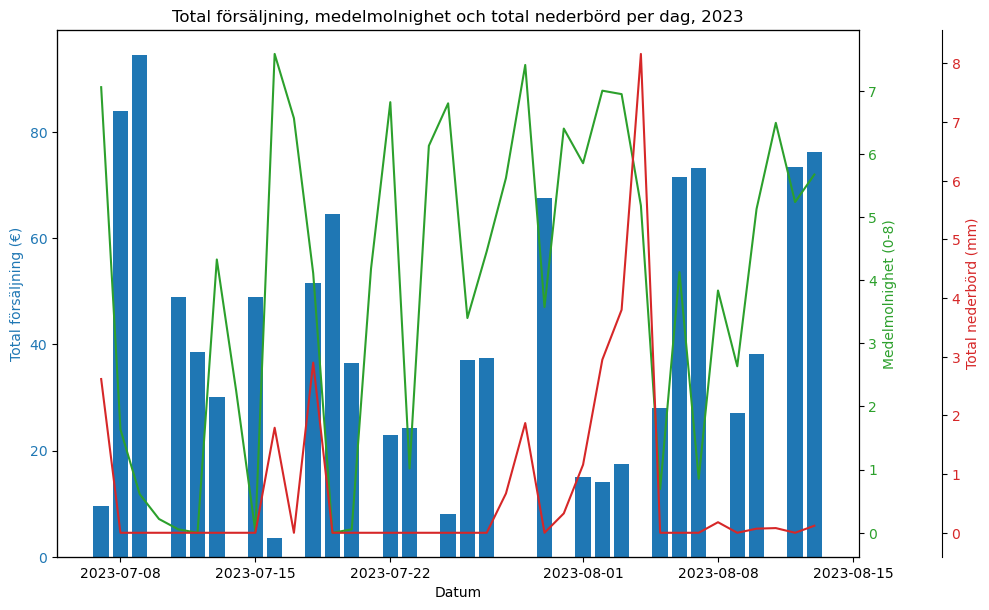

In [8]:
# visualisera tabellerna i en gemensam graf
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Datum')
ax1.set_ylabel('Total försäljning (€)', color=color)
ax1.bar(merged_data.index, merged_data['Price (Gross)'], color=color, width=0.8)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Medelmolnighet (0-8)', color=color)
ax2.plot(merged_data.index, merged_data['Cloud cover [1/8]'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()
color = 'tab:red'
ax3.spines['right'].set_position(('outward', 60))
ax3.set_ylabel('Total nederbörd (mm)', color=color)
ax3.plot(merged_data.index, merged_data['Precipitation amount [mm]'], color=color)
ax3.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title("Total försäljning, medelmolnighet och total nederbörd per dag, 2023")
plt.show()

In [9]:
# deskriptiv statistik (datapunkter, medelvärde, standardavvikelse, minimivärde, maximivärde och kvartiler)
display_table = merged_data.describe()

In [10]:
# namnge tabell, index och kolumner och visa tabellen
display_table.index = ['Antal värden (ingen enhet)', 'Medelvärde', 'Standardavvikelse', 'Minimivärde', '25% kvartil', '50% kvartil', '75% kvartil', 'Maximivärde']
display_table.rename(columns={'Price (Gross)': 'Försäljning (€)', 
                              'Cloud cover [1/8]': 'Medelmolnighet (0-8)', 
                              'Precipitation amount [mm]': 'Nederbörd (mm)'}, inplace=True)
display_table.style.format("{:.2f}").set_caption('Deskriptiv statistik för försäljning, medelmolnighet och nederbörd, 2023')

,Försäljning (€),Medelmolnighet (0-8),Nederbörd (mm)
Antal värden (ingen enhet),38.00,38.00,38.00
Medelvärde,30.05,3.95,0.70
Standardavvikelse,28.95,2.60,1.60
Minimivärde,0.00,0.00,0.00
25% kvartil,0.00,1.17,0.00
50% kvartil,25.62,4.25,0.00
75% kvartil,49.00,6.33,0.29
Maximivärde,94.50,7.58,8.16


In [11]:
# korrelationen mellan försäljning, nederbörd och molnighet
merged_data.corr()

,Price (Gross),Cloud cover [1/8],Precipitation amount [mm]
Price (Gross),1.000000,-0.478893,-0.282650
Cloud cover [1/8],-0.478893,1.000000,0.368814
Precipitation amount [mm],-0.282650,0.368814,1.000000


In [12]:
# kovariansen mellan försäljning, nederbörd och molnighet 
merged_data.cov()

,Price (Gross),Cloud cover [1/8],Precipitation amount [mm]
Price (Gross),838.044452,-35.976644,-13.104669
Cloud cover [1/8],-35.976644,6.734381,1.532847
Precipitation amount [mm],-13.104669,1.532847,2.564993
